## 5.3.1 특성 추출 기법

In [1]:
!git clone https://github.com/gilbutITbook/080289.git

fatal: destination path '080289' already exists and is not an empty directory.


In [2]:
!pip install opencv-python

In [3]:
### 라이브러리 임포트

import os
import time
import copy
import glob
import cv2  # 앞서 설치한 openCV 라이브러리
import shutil

import torch
import torchvision  # cv 용도의 패키지
import torchvision.transforms as transforms  # 데이터 전처리를 위해 사용되는 패키지
import torchvision.models as models  # 다양한 파이토치 네트워크를 사용할 수 있도록 와주는 패키지
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

- glob
  - 파일 경로에서 패턴 매칭(예: *.jpg, data/*.txt)을 할 수 있게 해줌
  - 특정 폴더 내에서 특정 확장자의 파일들을 한 번에 가져올 수 있어 유용
- shutil
  - 고수준 파일 연산(복사, 이동, 삭제 등)을 지원하는 표준 라이브러리

In [4]:
### 이미지 데이터 전처리 방법 정의

data_path = '/content/080289/chap05/data/catanddog/train/'

transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
train_dataset = torchvision.datasets.ImageFolder(data_path, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, num_workers=8, shuffle=True)

print(len(train_dataset))

385


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


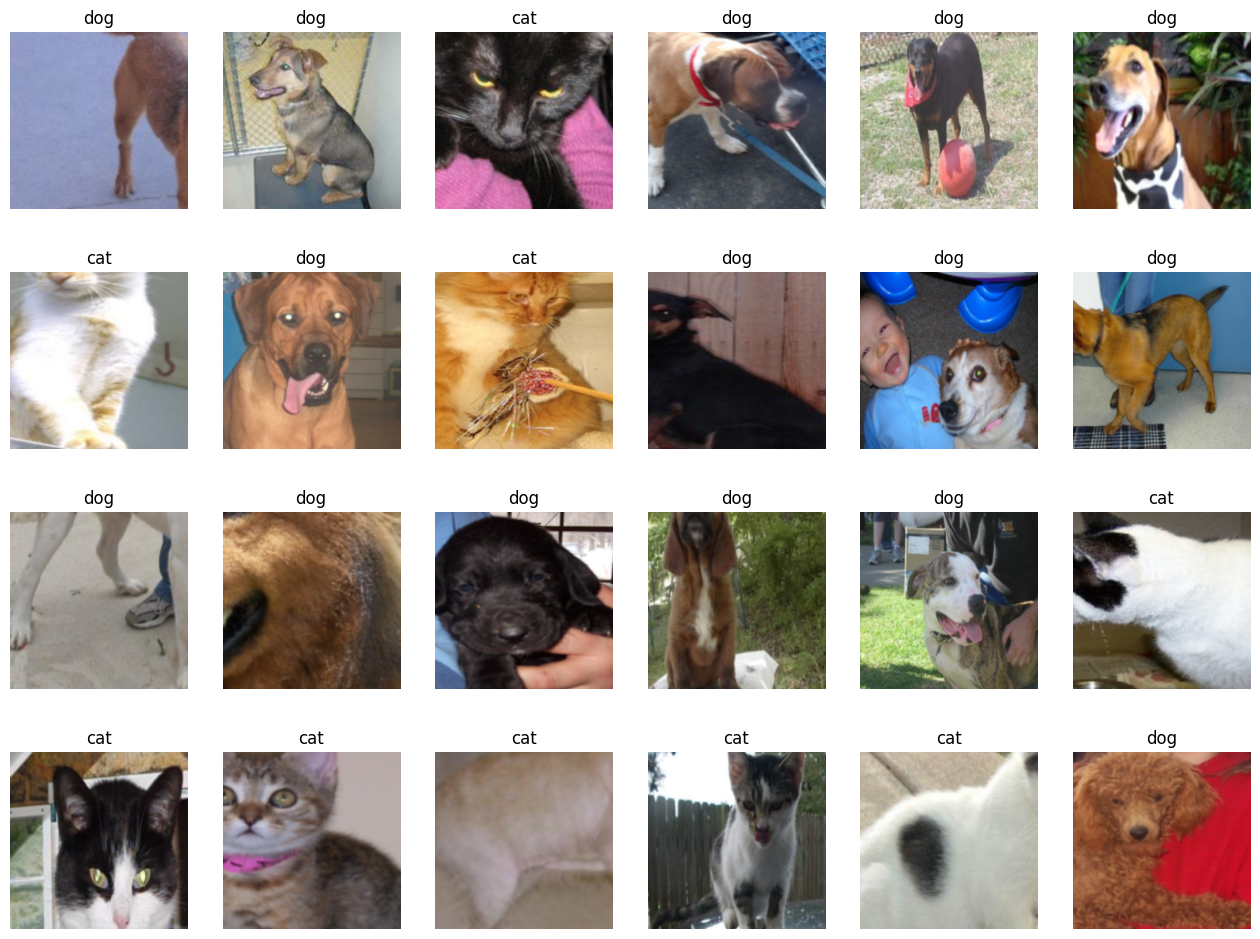

In [5]:
### 학습에 사용될 이미지 출력

import numpy as np
samples, labels = next(iter(train_loader))
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):  # 24개 이미지 데이터 출력
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])  # 레이블 정보(클래스)를 함께 출력
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [6]:
### 사전 훈련된 모델 내려받기

resnet18 = models.resnet18(pretrained=True)  # True로 설정: 사전 학습된 가중치를 내려받겠다는 의미

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 188MB/s]


In [7]:
### 사전 훈련된 모델의 파라미터 학습 여부 지정

def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
      for param in model.parameters():
        param.requires_grad = False

set_parameter_requires_grad(resnet18)

In [8]:
### ResNet18에 완전연결층 추가

resnet18.fc = nn.Linear(512, 2)  # 2: 클래스가 2개라는 의미

In [9]:
### 모델의 파라미터 값 확인

# model.named_parameters()는 모델에 접근하여 파라미터 값들을 가져올 때 사용
for name, param in resnet18.named_parameters():
    if param.requires_grad:
       print(name, param.data)

fc.weight tensor([[-0.0246, -0.0283,  0.0219,  ..., -0.0404,  0.0372, -0.0017],
        [-0.0109, -0.0228,  0.0212,  ...,  0.0141, -0.0358, -0.0406]])
fc.bias tensor([-0.0096, -0.0192])


In [10]:
### 모델 객체 생성 및 손실 함수 정의

model = models.resnet18(pretrained = True)

for param in model.parameters():  # 모델의 합성곱층 가중치 고정
  param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters():  # 완전연결층은 학습
  param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
### 모델 학습을 위한 함수 생성

def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time()  # 컴퓨터의 현재 시각을 구하는 함수
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):  # 에포크(13)만큼 반족
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:  # 데이터로더에 전달된 데이터만큼 반복
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad()  # 기울기 초기화(0으로 설정)
            outputs = model(inputs)  # 순전파 학습
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()  # 역전파 학습
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)  # 출력 결과와 레이블의 오차를 계산한 결과를 누적하여 저장
            running_corrects += torch.sum(preds == labels.data)  # 출력 결과와 레이블이 동일한지 확인한 결과를 누적하여 저장

        epoch_loss = running_loss / len(dataloaders.dataset)  # 평균 오차 계산
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)  # 평균 정확도 계산

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('/content/080289/chap05/data/catanddog/', '{0:0=2d}.pth'.format(epoch)))  # 모델 재사용을 위해 저장
        print()

    time_elapsed = time.time() - since  # 실행 시간(학습 시간)을 계산
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    return acc_history, loss_history  # 모델의 정확도, 오차 반환

In [12]:
### 파라미터 학습 결과를 옵티마이저에 전달

params_to_update = []
for name,param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)  # 파라미터 학습 결과를 저장
        print("\t",name)

optimizer = optim.Adam(params_to_update)  # 학습 결과를 옵티마이저에 전달

	 fc.weight
	 fc.bias


In [13]:
### 모델 학습

os.makedirs('catanddog', exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
Loss: 0.5406 Acc: 0.7117

Epoch 1/12
----------
Loss: 0.3720 Acc: 0.8442

Epoch 2/12
----------
Loss: 0.2990 Acc: 0.8987

Epoch 3/12
----------
Loss: 0.3349 Acc: 0.8364

Epoch 4/12
----------
Loss: 0.2485 Acc: 0.8987

Epoch 5/12
----------
Loss: 0.2446 Acc: 0.9013

Epoch 6/12
----------
Loss: 0.2120 Acc: 0.9351

Epoch 7/12
----------
Loss: 0.2136 Acc: 0.9221

Epoch 8/12
----------
Loss: 0.2311 Acc: 0.9039

Epoch 9/12
----------
Loss: 0.2345 Acc: 0.8987

Epoch 10/12
----------
Loss: 0.1937 Acc: 0.9403

Epoch 11/12
----------
Loss: 0.2087 Acc: 0.8987

Epoch 12/12
----------
Loss: 0.2609 Acc: 0.8831

Training complete in 0m 31s
Best Acc: 0.940260


In [14]:
### 테스트 데이터 호출 및 전처리

test_path = '/content/080289/chap05/data/catanddog/test/'

transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

98


In [15]:
### 테스트 데이터 평가 함수 생성

def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('/content/080289/chap05/data/catanddog/' + '*.pth')
    saved_models.sort()  # 불러온 .pth 파일들을 정렬
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:  # 테스트 반복
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():  # autograd를 사용하지 않겠다는 의미
                outputs = model(inputs)  # 데이터를 모델에 적용한 결과를 outputs에 저장

            _, preds = torch.max(outputs.data, 1)
            preds[preds >= 0.5] = 1  # torch.max로 출력된 값이 0.5보다 크면 올바르게 예측
            preds[preds < 0.5] = 0  # 작으면 틀리게 예측
            running_corrects += preds.eq(labels).int().sum()

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)  # 테스트 데이터의 정확도 계산
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))

    return acc_history

In [16]:
### 테스트 데이터를 평가 함수에 적용

val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['/content/080289/chap05/data/catanddog/00.pth', '/content/080289/chap05/data/catanddog/01.pth', '/content/080289/chap05/data/catanddog/02.pth', '/content/080289/chap05/data/catanddog/03.pth', '/content/080289/chap05/data/catanddog/04.pth', '/content/080289/chap05/data/catanddog/05.pth', '/content/080289/chap05/data/catanddog/06.pth', '/content/080289/chap05/data/catanddog/07.pth', '/content/080289/chap05/data/catanddog/08.pth', '/content/080289/chap05/data/catanddog/09.pth', '/content/080289/chap05/data/catanddog/10.pth', '/content/080289/chap05/data/catanddog/11.pth', '/content/080289/chap05/data/catanddog/12.pth']
Loading model /content/080289/chap05/data/catanddog/00.pth
Acc: 0.8776

Loading model /content/080289/chap05/data/catanddog/01.pth
Acc: 0.9082

Loading model /content/080289/chap05/data/catanddog/02.pth
Acc: 0.9286

Loading model /content/080289/chap05/data/catanddog/03.pth
Acc: 0.9082

Loading model /content/080289/chap05/data/catanddog/04.pth
Acc: 0.9286

Loa

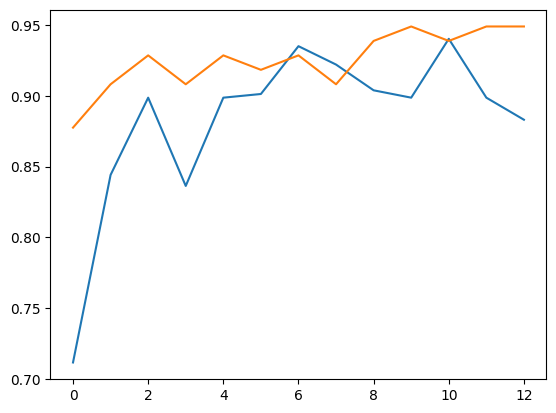

In [17]:
### 훈련과 테스트 데이터의 정확도를 그래프로 확인

plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

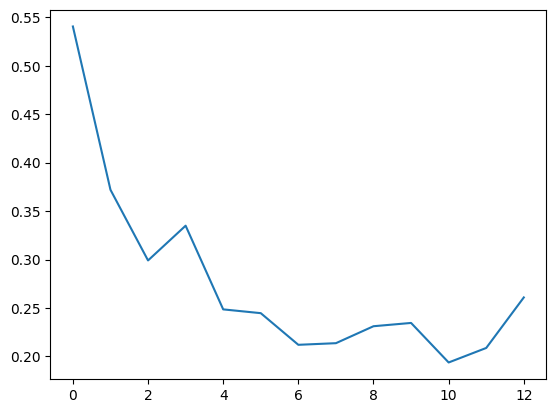

In [18]:
### 훈련 데이터의 오차에 대한 그래프 확인

plt.plot(train_loss_hist)
plt.show()

In [19]:
### 예측 이미지 출력을 위한 전처리 함수

def im_convert(tensor):
    image=tensor.clone().detach().numpy()
    image=image.transpose(1,2,0)
    image=image*(np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5)))
    image=image.clip(0,1)
    return image

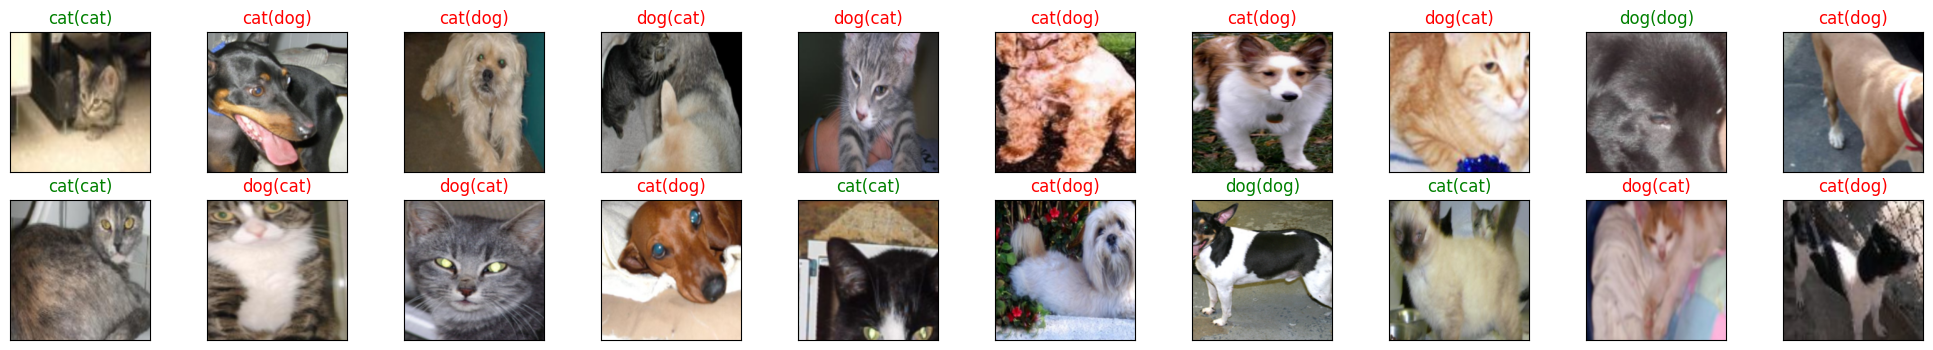

<Figure size 640x480 with 0 Axes>

In [20]:
### 개와 고양이 예측 결과 출력

classes = {0:'cat', 1:'dog'}

dataiter=iter(test_loader)  # 테스트 데이터셋을 가져옴
images, labels = next(iter(train_loader))  # 테스트 데이터셋에서 이미지와 레이블을 분리하여 가져옴
output=model(images)
_,preds=torch.max(output,1)

fig=plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
    plt.imshow(im_convert(images[idx]))  # 이미지 출력을 위해 위에서 정의한 im_convert 함수 이용
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]),str(classes[labels[idx].item()])),color=("green" if preds[idx]==labels[idx] else "red"))
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

## 5.4.1 특성 맵 시각화

In [21]:
!pip install pillow

In [22]:
### 필요한 라이브러리 호출

import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
### 설명 가능한 네트워크 생성

class XAI(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(XAI, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),  # inplace=Ture : 기존의 데이터를 연산 결과값으로 대체
            nn.Dropout(0.3),
            nn.Conv2d(64, 64, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(128, 128, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 512, bias=False),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512)
        x = self.classifier(x)

In [24]:
### 모델 객체화

model = XAI()
# model.to(device)  # model을 장치(CPU or GPU)에 할당
model.to('cpu')  # 이미지를 넘파이로 불러옴으로써 오류 방지 위해 gpu말고 cpu 사용
model.eval()

XAI(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True

In [25]:
### 특성 맵을 확인하기 위한 클래스 정의

class LayerActivations:
    features=[]
    def __init__(self, model, layer_num):
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        output = output
        #self.features = output.to(device).detach().numpy()
        self.features = output.detach().numpy()

    def remove(self):  # hook 삭제
        self.hook.remove()

torch.Size([1, 3, 100, 100])


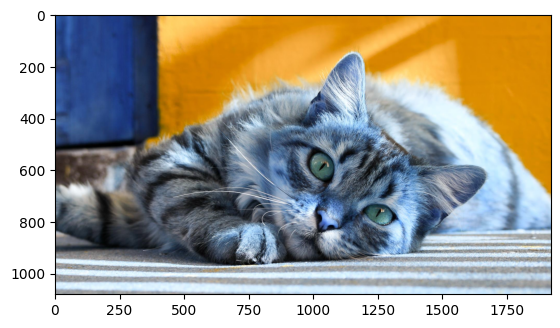

In [26]:
### 이미지 호출

img = cv2.imread('/content/080289/chap05/data/cat.jpg')
plt.imshow(img)
img = cv2.resize(img, (100, 100), interpolation=cv2.INTER_LINEAR)
img = ToTensor()(img).unsqueeze(0)

print(img.shape)

In [27]:
### (0): Conv2d 특성 맵 확인

result = LayerActivations(model.features, 0)  # 0번째 Conv2d 특성 맵 확인

model(img)
activations = result.features

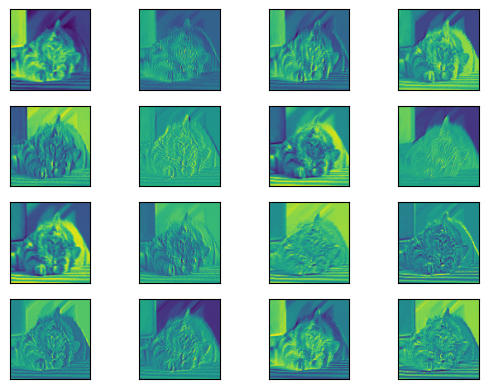

<Figure size 1200x800 with 0 Axes>

In [28]:
### 특성 맵 확인(시각적으로 표현)

fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()

In [29]:
### 20번쨰 계층에 대한 특성 맵

result = LayerActivations(model.features, 20)

model(img)
activations = result.features

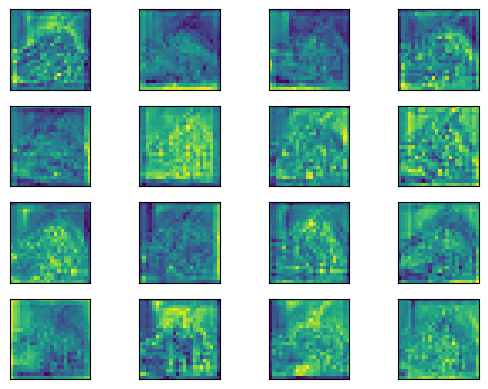

<Figure size 1200x800 with 0 Axes>

In [30]:
### 특성 맵 확인(시각적으로 표현)

fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()

In [31]:
### 40번째 계층에 대한 특성 맵

result = LayerActivations(model.features, 40)

model(img)
activations = result.features

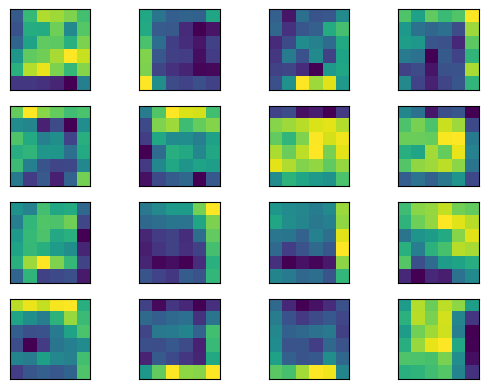

<Figure size 1200x800 with 0 Axes>

In [32]:
### 특성 맵 확인(시각적으로 표현)

fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()